# Predicción de número de órdenes de taxis en la próxima hora

## Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.
4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

In [1]:
# importar librerías

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy.stats import randint

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor


In [2]:
# Leer los datos
try: # intentar leer el archivo desde la computadora local
    data = pd.read_csv('./datasets/taxi.csv')
except: # intentar leer el archivo desde el servidor de la plataforma
    data = pd.read_csv('/datasets/taxi.csv')

In [3]:
# Explorar el archivo de manera general
display(data.info())
display(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


None

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [4]:
# Revisar valores ausentes y duplicados
print("Valores ausentes:")
print(data.isna().sum())
print("\nLíneas duplicadas:", data.duplicated().sum())

Valores ausentes:
datetime      0
num_orders    0
dtype: int64

Líneas duplicadas: 0


In [5]:
# Cambiar el tipo de datos de la columna datetime, pasarlos al índice y revisar la cronología
data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)
print("¿Los datos de fecha están en orden cronológico?:", data.index.is_monotonic_increasing)

¿Los datos de fecha están en orden cronológico?: True


In [6]:
# Revisar el rango de fechas
print("Fecha más antigüa:", data.index.min())
print("Fecha más reciente:", data.index.max())
# Revisar las primeras líneas de información
display(data.head())


Fecha más antigüa: 2018-03-01 00:00:00
Fecha más reciente: 2018-08-31 23:50:00


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Observamos que el número de órdenes de taxis se encuentra registrado y reportado cada 10 minutos, dado que la tarea es predecir el número de órdenes en la siguiente hora, haremos un remuestreo de los datos por hora y lo guardaremos en el mismo dataframe, ya que con esta configuración estaremos trabajando todos los modelos.

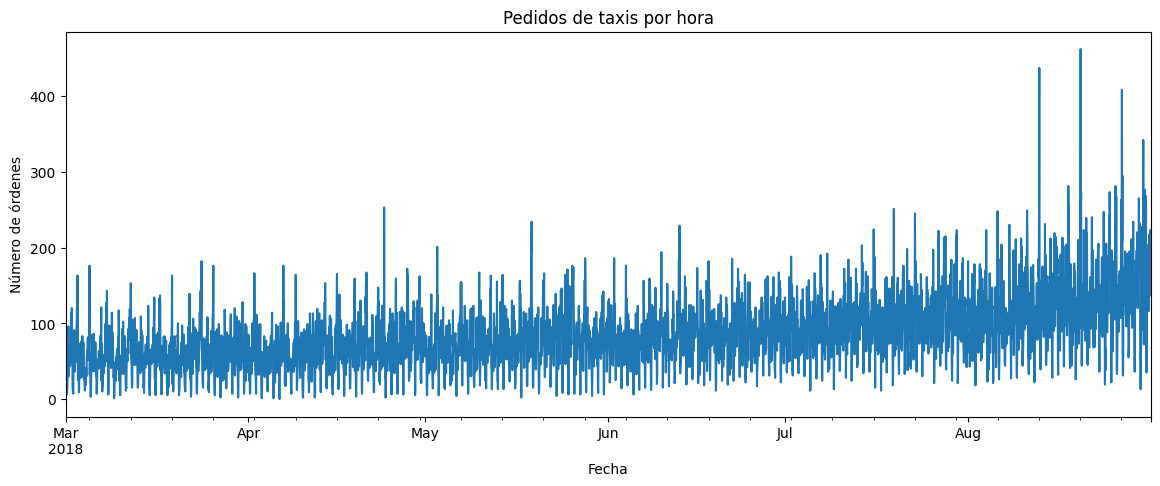

In [7]:
# Hacer remuestreo de los datos a intervalos de 1 hora y visualizar el gráfico
data = data.resample('1h').sum()
plt.figure(figsize=(14,5))
data.plot(ax=plt.gca(), legend=False)
plt.title("Pedidos de taxis por hora")
plt.xlabel("Fecha")
plt.ylabel("Número de órdenes")
plt.show()


## Análisis

In [8]:
# Definición de una función para graficar tendencias, estacionalidad y residuos
def plot_decomposed_data(dataset, suptitle, start_date = '2018-03-01', end_date = '2018-08-31'):
    
    decomposed = seasonal_decompose(dataset)
    
    plt.figure(figsize=(15, 10))
    
    # Graficar la serie original
    plt.suptitle(suptitle, fontweight='bold')
    plt.subplot(411)
    plt.title('Original data')
    decomposed.observed[start_date : end_date].plot(ax=plt.gca())
    plt.xlabel(None)
    plt.ylabel("Taxi Orders")
    
    # Graficar la tendencia
    plt.subplot(412)
    plt.title("Trend")
    decomposed.trend[start_date : end_date].plot(ax=plt.gca())
    plt.xlabel(None)
    plt.ylabel("Taxi Orders")
    
    # Graficar la estacionalidad
    plt.subplot(413)
    plt.title("Seasonality")
    decomposed.seasonal[start_date : end_date].plot(ax=plt.gca())
    plt.xlabel(None)
    plt.ylabel("Taxi Orders")
    
    # Graficar los residuos
    plt.subplot(414)
    plt.title("Residuals")
    decomposed.resid[start_date : end_date].plot(ax=plt.gca())
    plt.xlabel("Date time")
    plt.ylabel("Taxi Orders")
    plt.tight_layout()        

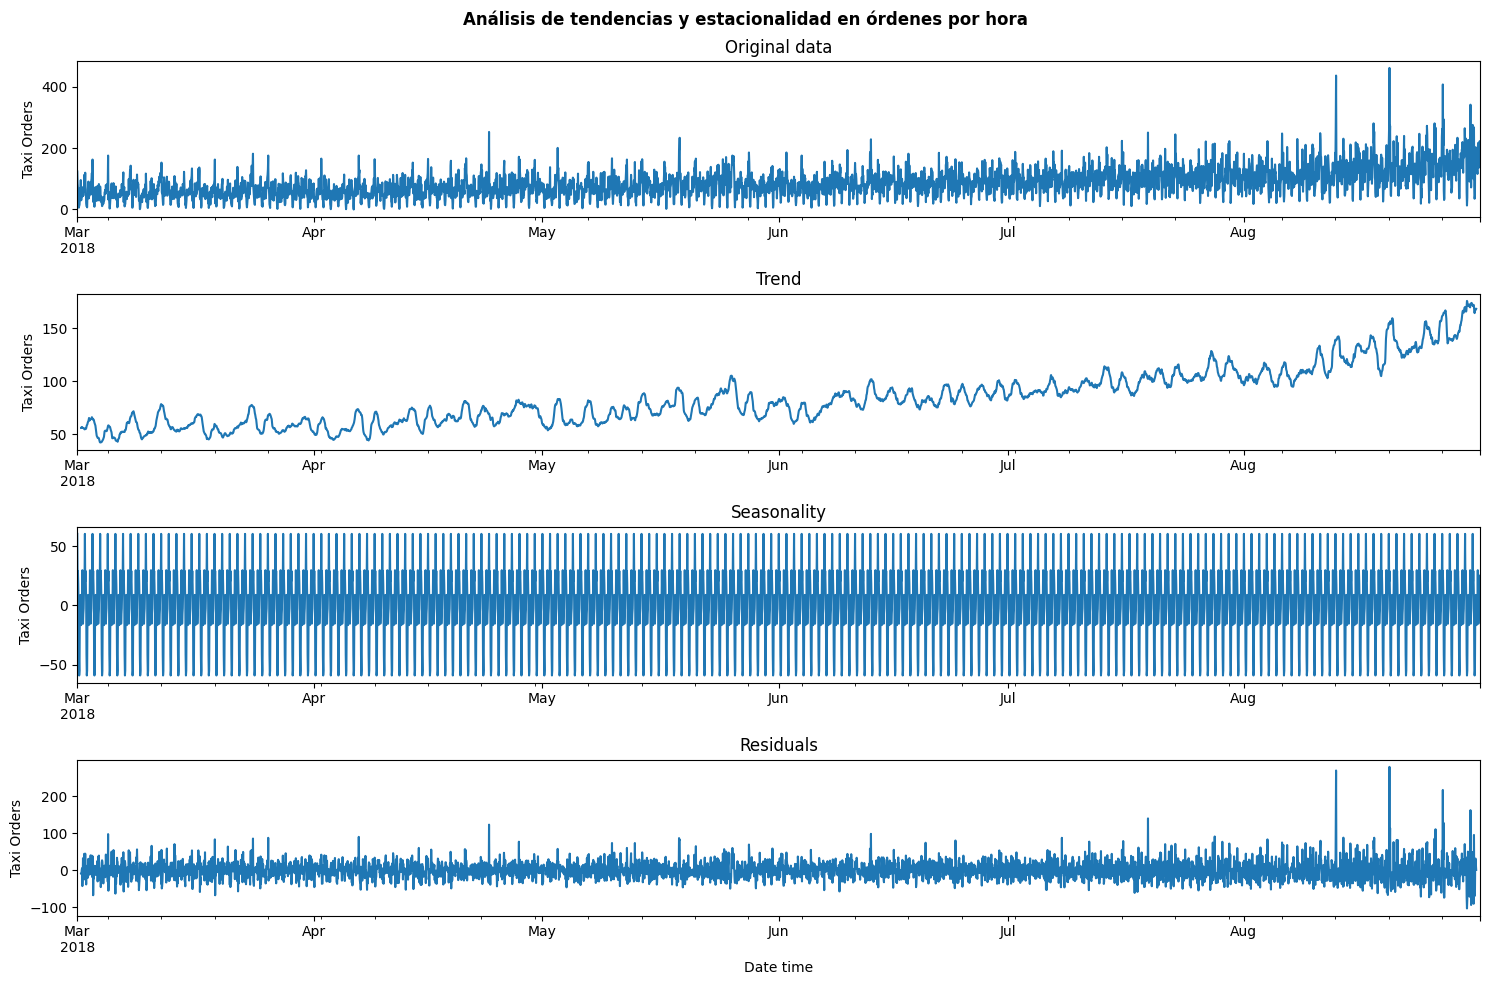

In [9]:
# Análisis de tendencias y estacionalidad en órdenes por día
plot_decomposed_data(data, "Análisis de tendencias y estacionalidad en órdenes por hora")

Podemos observar una tendencia al alza a partir del mes de Abril que se intensifica en Julio y Agosto. Por el lado de la estacionalidad, podemos ver que los datos tienen un claro patrón de estacionalidad que se mantiene constante a lo largo del periodo. Ahora analizaremos estos patrones agrupando la información en base diaria y posteriormente haremos diferentes cortes en las fechas para analizar más de cerca estos patrones.

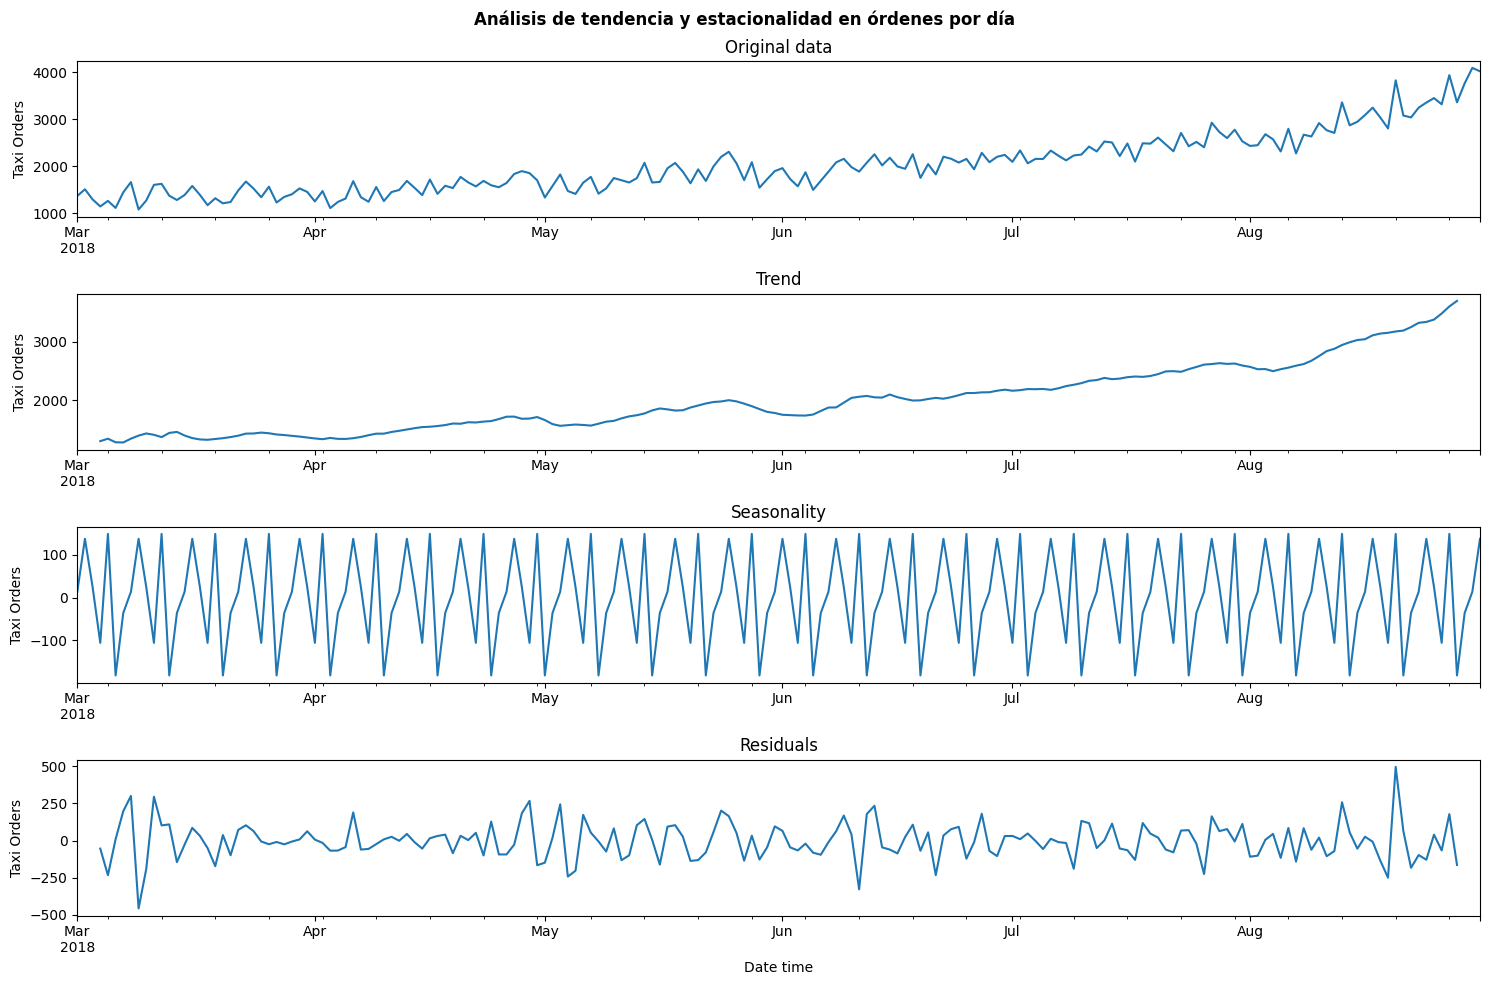

In [10]:
# Análisis de tendencias y estacionalidad agrupando la información por día
daily_data = data.resample('1D').sum()
plot_decomposed_data(daily_data, "Análisis de tendencia y estacionalidad en órdenes por día")

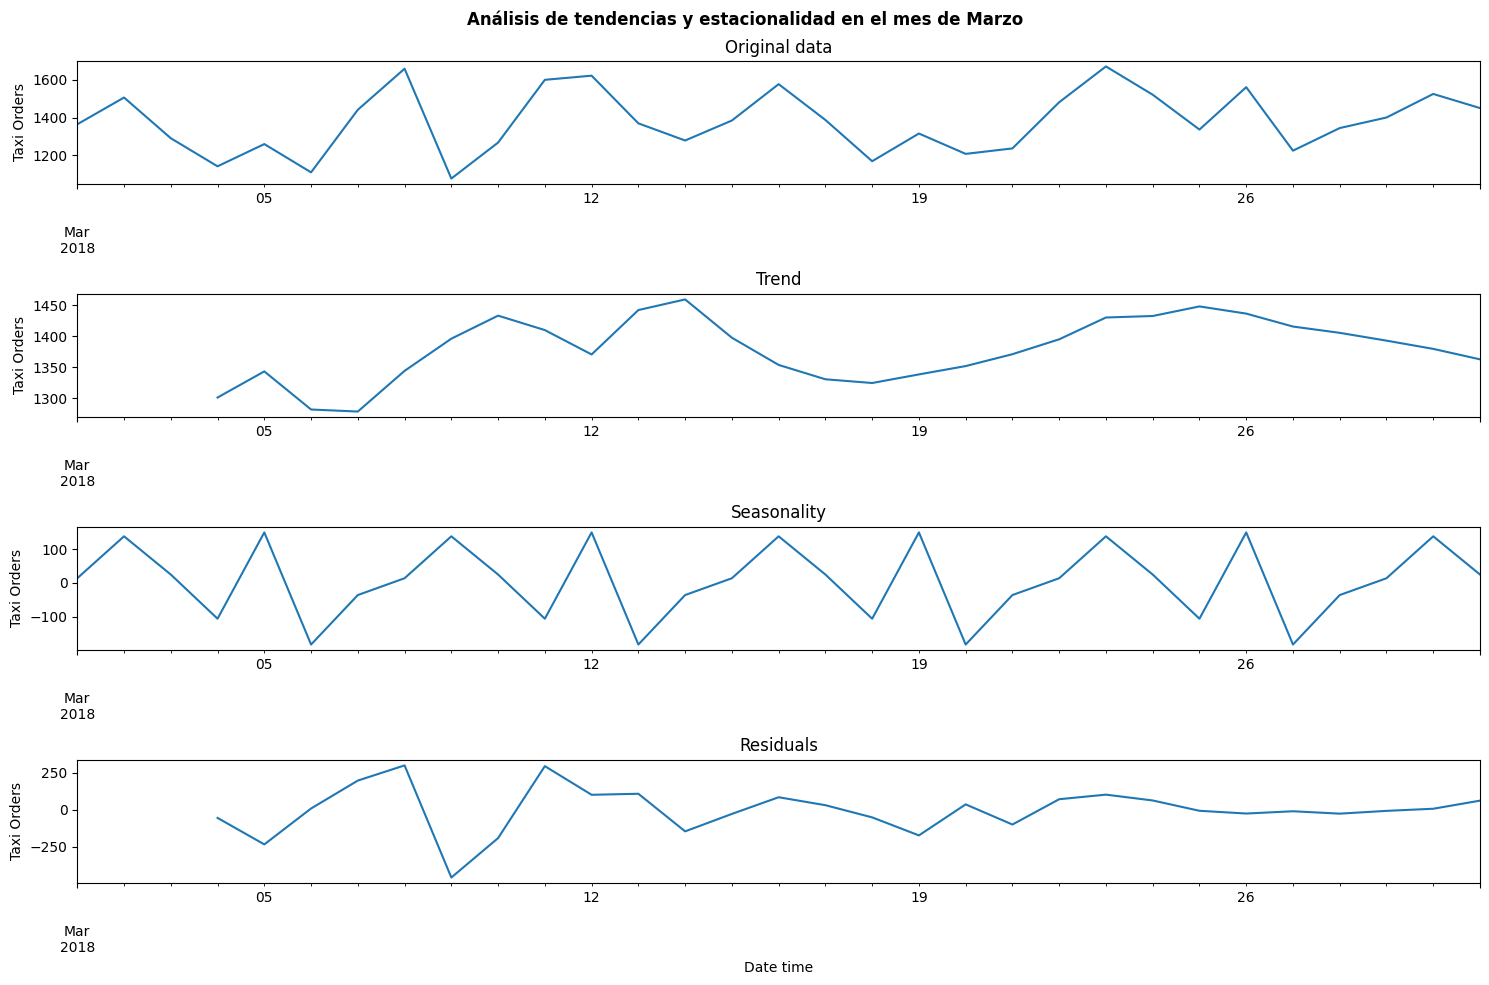

In [11]:
# Análisis de tendencias en el mes de Marzo
plot_decomposed_data(daily_data, "Análisis de tendencias y estacionalidad en el mes de Marzo", '2018-03-01', '2018-03-31')

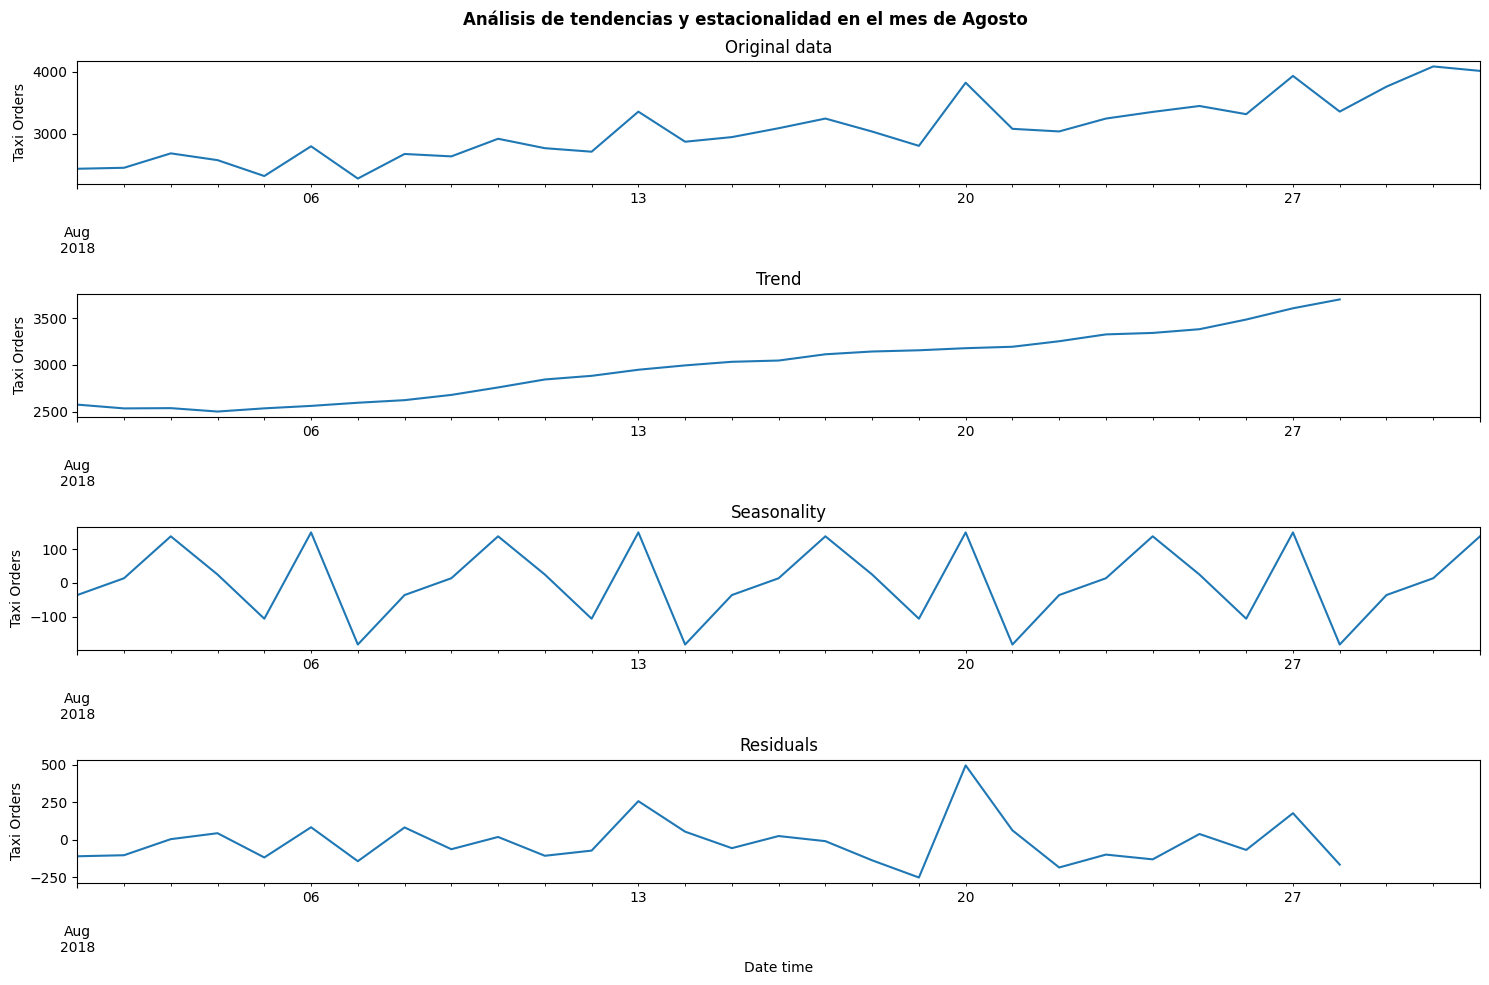

In [12]:
# Análisis de la estacionalidad en el mes de Agosto
plot_decomposed_data(daily_data, "Análisis de tendencias y estacionalidad en el mes de Agosto", '2018-08-01', '2018-08-31')

De las gráficas anteriores podemos apreciar que en el mes de Marzo no hay una tendencia clara en los datos, comparado con el mes de Agosto en el cual se aprecia una clara tendencia al alza. En la estacionalidad de ambos meses, podemos ver que el patrón se repite cada 7 días con picos marcados en los días Lunes y los puntos más bajos en los días Martes. Ahora analizaremos la información en base horaria para identificar si hay patrones similares dentro de cada día.

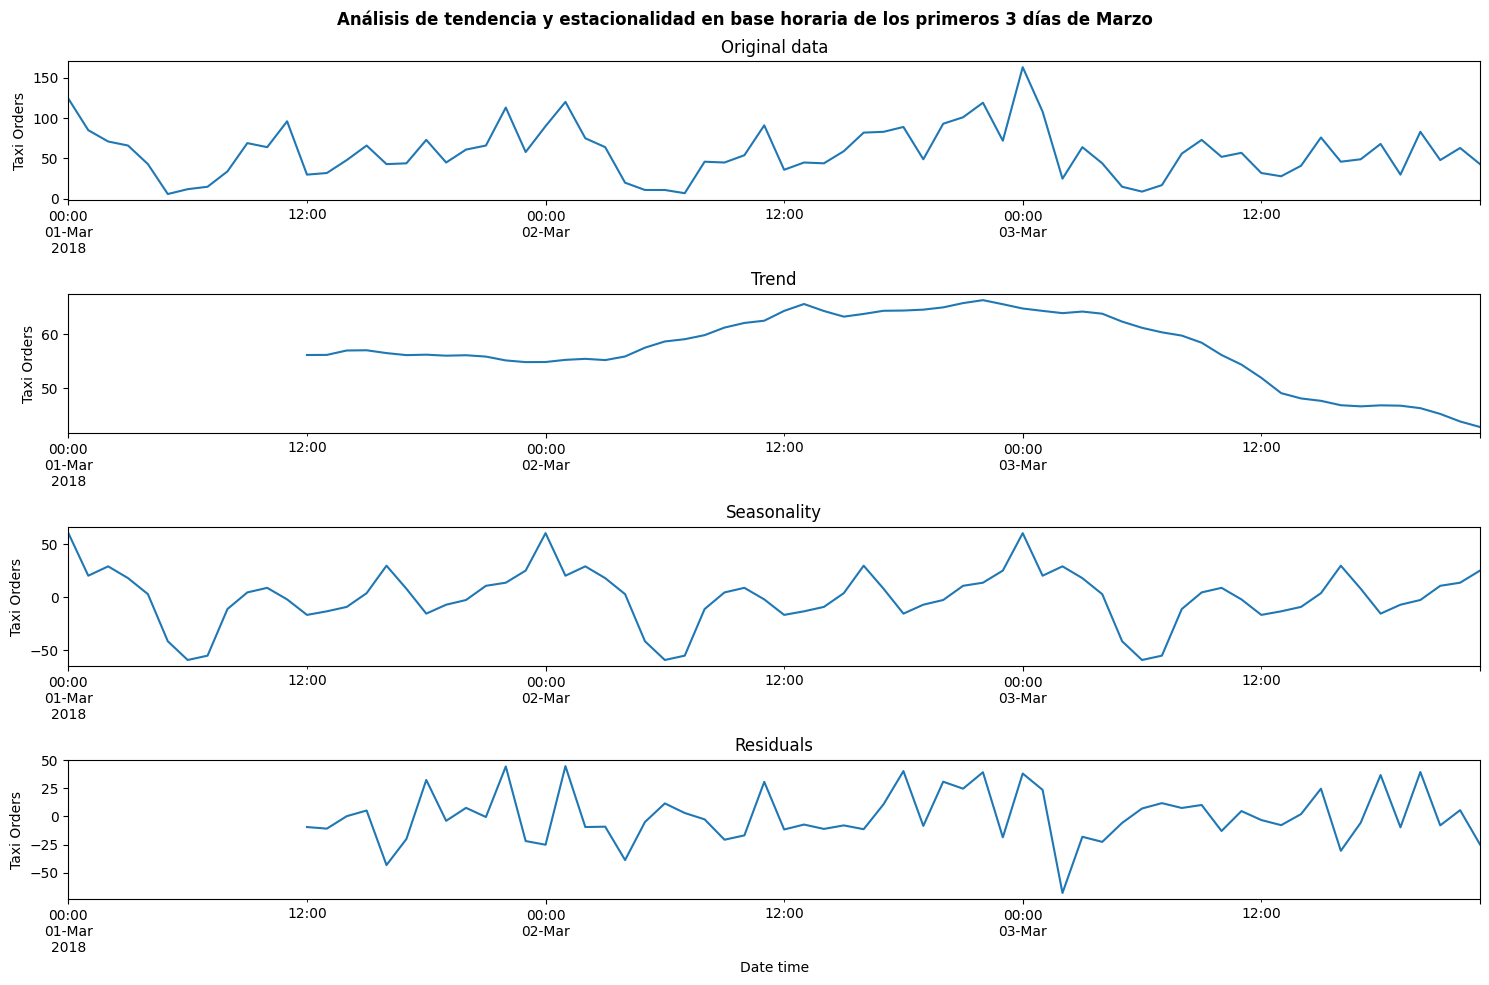

In [13]:
# Análisis de tendencia y estacionalidad en dos días de Marzo
plot_decomposed_data(data, "Análisis de tendencia y estacionalidad en base horaria de los primeros 3 días de Marzo", '2018-03-01', '2018-03-03')

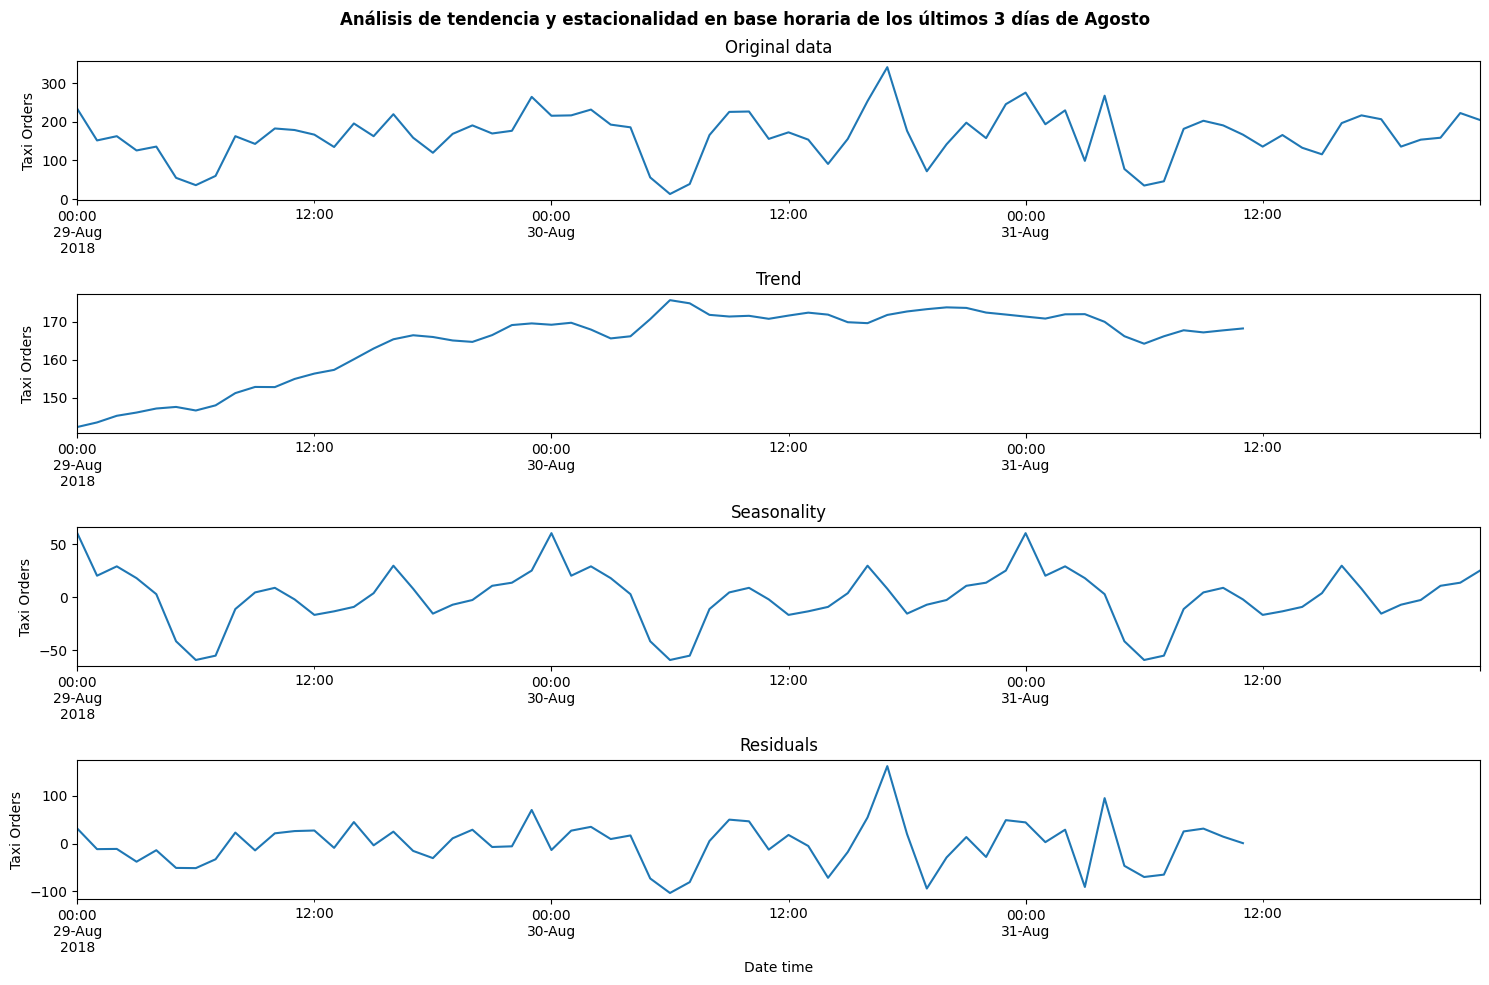

In [14]:
plot_decomposed_data(data, "Análisis de tendencia y estacionalidad en base horaria de los últimos 3 días de Agosto", '2018-08-29', '2018-08-31')

Podemos observar en las gráficas que sí hay un patrón que se repite a lo largo del día con los puntos más elevados a la media noche y los puntos más bajos a las 6 de la mañana, este patrón se mantiene en los meses observados. Ahora haremos el análisis de la media y la desviación estándar para determinar si la serie de tiempo es estacionaria o no.

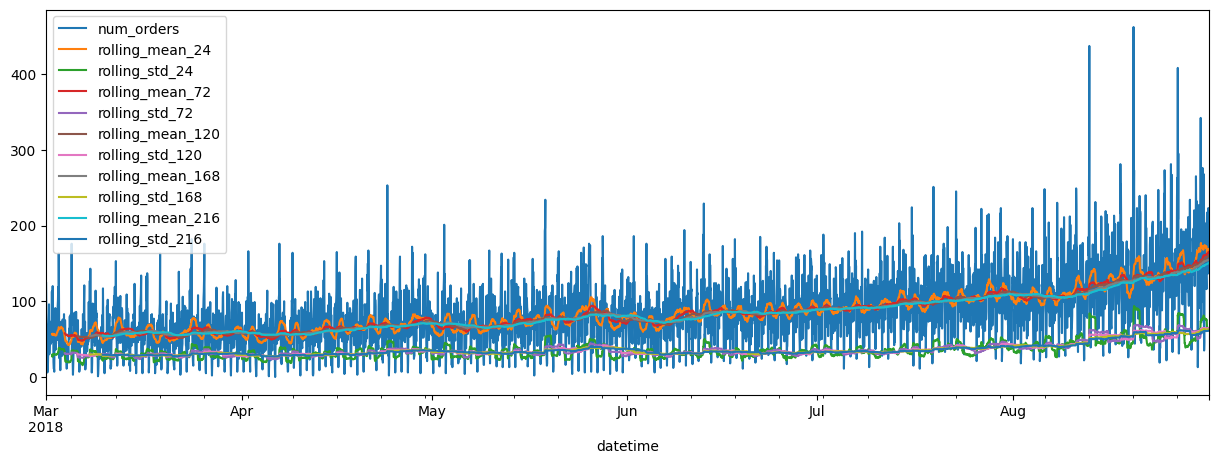

In [15]:
# Análisis de estacionariedad
# Calcular la media móvil utilizando diferentes valores de ventana en múltiplos de 24 horas
stationarity_test_data = data.copy()
for i in range(24, 220, 48):
    rolling_mean = f'rolling_mean_{i}'
    rolling_std = f'rolling_std_{i}'
    stationarity_test_data[rolling_mean] = stationarity_test_data['num_orders'].rolling(i).mean()
    stationarity_test_data[rolling_std] = stationarity_test_data['num_orders'].rolling(i).std()
plt.figure(figsize=(15,5))
stationarity_test_data.plot(ax=plt.gca())
plt.show()

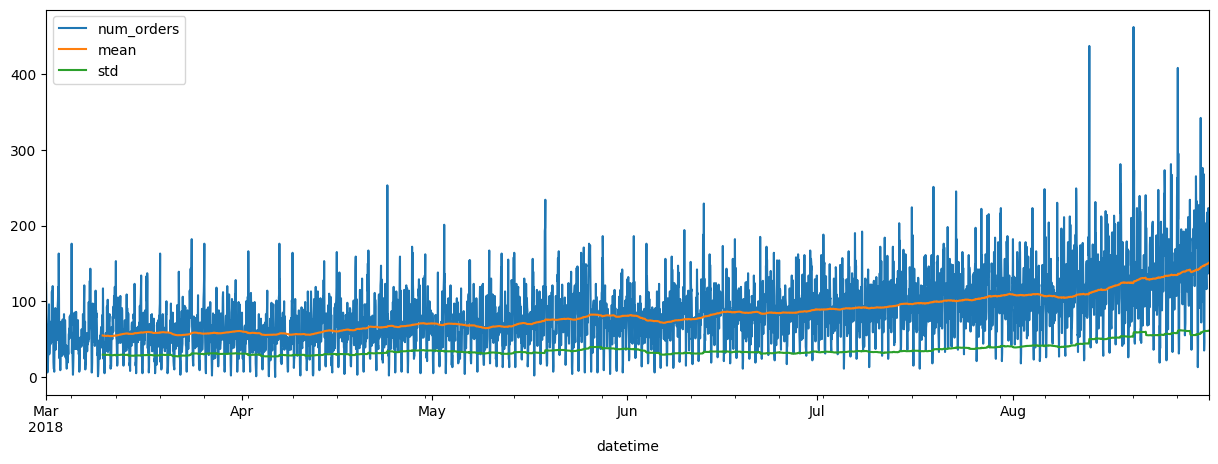

In [16]:
# Seleccionamos la ventana de 216 y eliminamos las demás
stationarity_test_data = stationarity_test_data[['num_orders', 'rolling_mean_216', 'rolling_std_216']]
stationarity_test_data.columns = ['num_orders', 'mean', 'std']
plt.figure(figsize=(15,5))
stationarity_test_data.plot(ax=plt.gca())
plt.show()

Podemos observar que la media y la distribución estándar aumentan ligeramente con el tiempo, lo que supone que la serie no es estacionaria. Para corroborar esto, haremos la prueba de Dickey-Fuller Aumentada (ADF), que nos indicará si la serie es estacionaria o no. La hipótesis nula de esta prueba es que la serie no es estacionaria, por lo que si el valor p es menor a 0.05 podemos rechazar la hipótesis nula y concluir que la serie es estacionaria.

In [17]:
# Realizar la prueba ADF sobre la serie agrupada por hora
print("Prueba estadística ADF para determinar si la serie es estacionaria")
adf_result = adfuller(stationarity_test_data['num_orders'])
alpha = 0.05

# Mostrar los resultados
print("Resultados de la prueba ADF:")
print("Estadístico ADF:", adf_result[0])
print("p-value:", adf_result[1])
print("Número de retardos utilizados:", adf_result[2])
print("Número de observaciones:", adf_result[3])
print("Valores críticos:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value}")

if adf_result[1] < alpha:
    print("\n\033[1mSe rechaza la hipótesis nula, por lo tanto, la serie es estacionaria.\033[0m")
else:
    print("\n\033[1mNo se rechaza la hipótesis nula, por lo tanto, no hay evidencia suficiente para afirmar que la serie es estacionaria.\033[0m")


Prueba estadística ADF para determinar si la serie es estacionaria
Resultados de la prueba ADF:
Estadístico ADF: -3.0689242890279527
p-value: 0.02894005140261315
Número de retardos utilizados: 30
Número de observaciones: 4385
Valores críticos:
   1%: -3.431842162413052
   5%: -2.8621993540813637
   10%: -2.567120978470452

Se rechaza la hipótesis nula, por lo tanto, la serie es estacionaria.


## Formación

A continuación vamos a crear las características para entrenar los diferentes modelos de machine learning que estaremos probando. Las características que crearemos serán características de calendario, características de desfase, la media móvil y la desviación estándar móvil.
Definiremos también la métrica RMSE para utilizar en todas las pruebas.

In [18]:
# Definir una función para crear las características
def make_features(data, max_lag, rolling_window_size):
    
    data_temp = data.copy()
    
    # Características de calendario
    data_temp['hour'] = data_temp.index.hour
    data_temp['day'] = data_temp.index.day
    data_temp['day_of_week'] = data_temp.index.dayofweek
    data_temp['month'] = data_temp.index.month
    
    # Características de desfase
    for lag in range(1, max_lag + 1):
        data_temp['lag_{}'.format(lag)] = data_temp['num_orders'].shift(lag)

    # Características estadísticas
    data_temp['rolling_mean'] = data_temp['num_orders'].shift().rolling(rolling_window_size).mean()
    data_temp['rolling_std'] = data_temp['num_orders'].shift().rolling(rolling_window_size).std()
    
    return data_temp

In [19]:
# Definir la métrica a utilizar
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Definir el evaluador a utilizar
rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Definir el número de splits a utilizar en cross validation
tscv = TimeSeriesSplit(n_splits=5)


### Creación de características
Para preparar el conjunto de datos que estaremos utilizando, primero vamos a eliminar las columnas de visualización con la media móvil y la desviación estándar móvil para posteriormente crear las características que utilizaremos. Los parámetros a utilizar en la creación de características de desfase y el tamaño de ventana en las características estadísticas se determinarán de manera experimental.

In [20]:
# Conservamos el dataset original en una variable independiente
original_data = data.copy()

In [21]:
# Probar diferentes parámetros para las características de desfase y tamaño de ventana
# Declarar un diccionario para guardar los valores de la prueba
best_features_results = {
    'window_size' : [],
    'lag' : [],
    'RMSE' : []
} 
# Probaremos todos los valores yendo más allá de las 24 horas
for window_size in range(2, 31):
    for lag in range(1, 31):
        # Crear las características a probar
        data = make_features(original_data, lag, window_size)
        # Dividir el conjunto en entrenamiento y prueba
        train, test = train_test_split(data, shuffle=False, test_size=0.1)
        train.dropna(inplace=True)
        # Seleccionar las características y los objetivos para los conjuntos de entrenamiento y prueba
        features_train = train.drop('num_orders', axis=1)
        target_train = train['num_orders']
        features_test = test.drop('num_orders', axis=1)
        target_test = test['num_orders']
        # Probar el modelo
        model = LinearRegression()
        model.fit(features_train, target_train)
        y_pred_test = model.predict(features_test)
        rmse_score = rmse(target_test, y_pred_test)
        # Guardar los resultados
        best_features_results['window_size'].append(window_size)
        best_features_results['lag'].append(lag)
        best_features_results['RMSE'].append(rmse_score)       


In [22]:
# Analizar los resultados
best_features_results_df = pd.DataFrame(best_features_results)
best_features_results_df.sort_values(by='RMSE', inplace=True)
display(best_features_results_df.head())

,window_size,lag,RMSE
681,24,22,44.582049
680,24,21,44.993574
593,21,24,45.311194
563,20,24,45.336706
594,21,25,45.390313


Se probaron todos los valores posibles para los parámetros de características de desfase y tamaño de ventana considerando la estacionalidad de los días. Por lo resultados obtenidos en la tabla anterior podemos ver que el tamaño de ventana de 24 horas arroja los mejores resultados junto con un desfase máximo de 22 horas. Usaremos estos valores para generar las características en todos los datasets que estaremos usando para probar los diferentes modelos.

In [23]:
# Creación de características y conjuntos de entrenamiento y prueba
data = make_features(original_data, 22, 24)
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train.dropna(inplace=True)
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']
print("Tamaño del conjunto de entrenamiento:", train.shape)
print("Porcentaje del conjunto de entrenamiento con respecto al inicial: {:.2f} %".format(train.shape[0]/data.shape[0]*100))
print("Tamaño del conjunto de prueba:", test.shape)
print("Porcentaje del conjunto de prueba con respecto al inicial: {:.2f} %".format(test.shape[0]/data.shape[0]*100))


Tamaño del conjunto de entrenamiento: (3950, 29)
Porcentaje del conjunto de entrenamiento con respecto al inicial: 89.45 %
Tamaño del conjunto de prueba: (442, 29)
Porcentaje del conjunto de prueba con respecto al inicial: 10.01 %


In [24]:
# Definir una función para entrenar y evaluar los modelos sin ajuste de hiperparámetros
def model_no_tuning(model_name, model):
    # Entrenar el modelo utilizando validación cruzada
    model_score = round(abs(cross_val_score(model, features_train, target_train, cv=tscv, scoring=rmse_scorer).mean()), 3)
    # Presentar los resultados
    print("Cross Validation RMSE for {} = {}".format(model_name, model_score))
    return model_score

In [25]:
# Definirn una función para entrenar y evaluar los modelos con ajuste de hiperparámetros
def model_tuning(model_name, model, param_dist):
    # Iniciando el objeto RandomizedSearchCV
    rnd_search = RandomizedSearchCV(model, param_distributions=param_dist, scoring=rmse_scorer, n_iter=10, cv=tscv, n_jobs=4, random_state=12345)
    # Entrenar el modelo
    rnd_search.fit(features_train, target_train)
    # Presentar los resultados
    print("Best parameters:", rnd_search.best_params_)
    print("Best CV RMSE score for {} = {:.3f}".format(model_name, abs(rnd_search.best_score_)))
    return rnd_search.best_params_, round(abs(rnd_search.best_score_), 3), rnd_search.best_estimator_

In [26]:
# Definir una estructura para guardar los resultados de los modelos y sus hiperparámetros
results = {}

### Regresión Lineal

In [27]:
# Entrenar un modelo de regresión lineal como línea base 
model_name = 'Linear Regression'
results[model_name] = {}
results[model_name]['best_model'] = LinearRegression()
results[model_name]['best_model_score'] = model_no_tuning(model_name, results[model_name]['best_model'])
results[model_name]['best_params'] = None

Cross Validation RMSE for Linear Regression = 27.581


### Árbol de decisión

In [28]:
# Entrenar el modelo sin ajuste de hiperparámetros
model_name = 'Decission Tree Regressor'
results[model_name] = {}
results[model_name]['best_model'] = DecisionTreeRegressor(random_state=12345)
results[model_name]['best_model_score'] = model_no_tuning(model_name, results[model_name]['best_model'])
results[model_name]['best_params'] = None

Cross Validation RMSE for Decission Tree Regressor = 34.97


In [29]:
# Entrenar el modelo con ajuste de hiperparámetros
model_name = 'Decission Tree Regressor'
param_dist = {'max_depth' : randint(1, 21)}
best_params, best_score, best_model = model_tuning(model_name, results[model_name]['best_model'], param_dist)
if best_score < results[model_name]['best_model_score']:
    results[model_name]['best_params'] = best_params
    results[model_name]['best_model_score'] = best_score
    results[model_name]['best_model'] = best_model
    

Best parameters: {'max_depth': 5}
Best CV RMSE score for Decission Tree Regressor = 30.972


### Bosque aleatorio

In [30]:
# Entrenar el modelo sin ajuste de hiperparámetros
model_name = 'Random Forest Regressor'
results[model_name] = {}
results[model_name]['best_model'] = RandomForestRegressor(random_state=12345)
results[model_name]['best_model_score'] = model_no_tuning(model_name, results[model_name]['best_model'])
results[model_name]['best_params'] = None

Cross Validation RMSE for Random Forest Regressor = 25.23


In [31]:
# Entrenar el modelo con ajuste de hiperparámetros
model_name = 'Random Forest Regressor'
param_dist = {
    'max_depth' : randint(1, 21),
    'n_estimators' : randint(10, 201),
    
    }
best_params, best_score, best_model = model_tuning(model_name, results[model_name]['best_model'], param_dist)
if best_score < results[model_name]['best_model_score']:
    results[model_name]['best_params'] = best_params
    results[model_name]['best_model_score'] = best_score
    results[model_name]['best_model'] = best_model

Best parameters: {'max_depth': 15, 'n_estimators': 115}
Best CV RMSE score for Random Forest Regressor = 25.245


### XGBoost

In [32]:
# Entrenar el modelo sin ajuste de hiperparámetros
model_name = 'XG Boost Regressor'
results[model_name] = {}
results[model_name]['best_model'] = XGBRegressor()
results[model_name]['best_model_score'] = model_no_tuning(model_name, results[model_name]['best_model'])
results[model_name]['best_params'] = None

Cross Validation RMSE for XG Boost Regressor = 26.452


In [33]:
# Entrenar el modelo con ajuste de hiperparámetros
model_name = 'XG Boost Regressor'
param_dist = {
    'max_depth' : randint(1, 21),
    'n_estimators' : randint(10, 201),
    'eta' : [0.3, 0.1, 0.01],
    'subsample' : [0.3, 0.6, 1.0],
    'colsample_bytree' : [0.3, 0.6, 1.0],
    }
best_params, best_score, best_model = model_tuning(model_name, results[model_name]['best_model'], param_dist)
if best_score < results[model_name]['best_model_score']:
    results[model_name]['best_params'] = best_params
    results[model_name]['best_model_score'] = best_score
    results[model_name]['best_model'] = best_model

Best parameters: {'colsample_bytree': 1.0, 'eta': 0.1, 'max_depth': 2, 'n_estimators': 174, 'subsample': 0.6}
Best CV RMSE score for XG Boost Regressor = 25.884


### CatBoost

In [34]:
# Entrenar el modelo sin ajuste de hiperparámetros
model_name = 'Cat Boost Regressor'
results[model_name] = {}
results[model_name]['best_model'] = CatBoostRegressor(verbose=False)
results[model_name]['best_model_score'] = model_no_tuning(model_name, results[model_name]['best_model'])
results[model_name]['best_params'] = None

Cross Validation RMSE for Cat Boost Regressor = 24.943


In [35]:
# Entrenar el modelo con ajuste de hiperparámetros
model_name = 'Cat Boost Regressor'
param_dist = {
    'depth' : [2, 5],
    'n_estimators' : randint(10, 201),
    'subsample' : [0.6, 1.0],
    }
best_params, best_score, best_model = model_tuning(model_name, results[model_name]['best_model'], param_dist)
if best_score < results[model_name]['best_model_score']:
    results[model_name]['best_params'] = best_params
    results[model_name]['best_model_score'] = best_score
    results[model_name]['best_model'] = best_model

Best parameters: {'depth': 5, 'n_estimators': 176, 'subsample': 1.0}
Best CV RMSE score for Cat Boost Regressor = 25.522


### LightGBM

In [36]:
# Entrenar el modelo sin ajuste de hiperparámetros
model_name = 'Light GBM Regressor'
results[model_name] = {}
results[model_name]['best_model'] = LGBMRegressor(verbose=-1)
results[model_name]['best_model_score'] = model_no_tuning(model_name, results[model_name]['best_model'])
results[model_name]['best_params'] = None

Cross Validation RMSE for Light GBM Regressor = 25.171


In [37]:
# Entrenar el modelo con ajuste de hiperparámetros
model_name = 'Light GBM Regressor'
param_dist = {
    'max_depth' : randint(1, 17),
    'n_estimators' : randint(10, 201),
    'subsample' : [0.3, 0.6, 1.0],
    }
best_params, best_score, best_model = model_tuning(model_name, results[model_name]['best_model'], param_dist)
if best_score < results[model_name]['best_model_score']:
    results[model_name]['best_params'] = best_params
    results[model_name]['best_model_score'] = best_score
    results[model_name]['best_model'] = best_model

Best parameters: {'max_depth': 9, 'n_estimators': 193, 'subsample': 0.6}
Best CV RMSE score for Light GBM Regressor = 25.100


In [38]:
# Presentar resultados obtenidos en esta etapa
print("\033[1mMODEL", " " * (21), "CV RMSE Score\033[0m")
for key, value in results.items():
    print(key, " " * (26-len(key)), value['best_model_score'])

MODEL                       CV RMSE Score
Linear Regression           27.581
Decission Tree Regressor    30.972
Random Forest Regressor     25.23
XG Boost Regressor          25.884
Cat Boost Regressor         24.943
Light GBM Regressor         25.1


#### Observaciones:
Se utilizaron 6 modelos de machine learning para probarlos sin ajuste de hiperparámetros y con ajuste de hiperparámetros, obteniendo los resultados que se muestran en la tabla de arriba. Vale la pena resaltar que estos se realizaron con el método Randomized Search CV utilizando validación cruzada en el set de entrenamiento. Los valores se fueron almacenando de acuerdo al menor valor obtenido para cada modelo ya sea con ajuste de hiperparámetros o sin él, el que fuese mejor. El mejor de todos los valores obtenidos lo tenemos con el modelo Cat Boost sin ajuste de hiperparámetros. A continuación crearemos una función para probar todos los modelos en el set de prueba y reportar los resultados finales. El mejor modelo con los mejores hiperparámetros fue almacenado en el diccionario que utilizaremos para esta tarea.

## Prueba

In [39]:
# Definir una función para evaluar los modelos con el set de prueba
def test_models(model_name, model):
    model.fit(features_train, target_train)
    y_pred_test = model.predict(features_test)
    results[model_name]['final_RMSE'] = round(rmse(target_test, y_pred_test), 3)

In [40]:
# Realizar la prueba de cada modelo en el set de prueba
for model_name in results.keys():
    test_models(model_name, results[model_name]['best_model'])

In [41]:
# Presentar resultados en una tabla resaltando los valores mínimos
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df.drop(['best_model', 'best_params'], axis=1, inplace=True)
results_df.index.name = 'Model'
results_df_styled = results_df.style.applymap(lambda x: 'color: red' if x in results_df.min().values else '')
display(results_df_styled.format("{:.3f}"))

C:\Users\Laptop\AppData\Local\Temp\ipykernel_10988\2831673115.py:5: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  results_df_styled = results_df.style.applymap(lambda x: 'color: red' if x in results_df.min().values else '')


,best_model_score,final_RMSE
Model,,
Linear Regression,27.581,44.582
Decission Tree Regressor,30.972,56.983
Random Forest Regressor,25.230,44.875
XG Boost Regressor,25.884,49.232
Cat Boost Regressor,24.943,41.432
Light GBM Regressor,25.100,42.383


## Conclusión General:
En este proyecto se analizaron los datos proporcionados por la compañía Sweet Lift Taxi con el propósito de generar un modelo predictivo que ayude a determinar con precisión la cantidad de taxis que se necesitarán dentro de la siguiente hora. Dado que es un problema de series temporales se utilizaron técnicas para determinar los principales componentes de series de tiempo como tendencias y estacionalidad. Se utilizó también una prueba estadística para determinar si la serie temporal era estacionaria o no. Se generaron las características para entrenar los modelos utilizando características de tiempo y de desfase.

Se probaron 6 diferentes modelos de machine learning y que se muestran en la tabla de arriba, donde podemos ver resaltado en rojo que el modelo Cat Boost fue el que generó los mejores resultados utilizando la métrica RMSE y donde el error más bajo es el que representa el mejor modelo en órdenes de taxis por hora. Con este modelo la métrica que se obtuvo en el conjunto de prueba es de 41.432 que es más baja que la mínima esperada de 48.
